<a href="https://colab.research.google.com/github/OliverKris/computer-price-prediction/blob/main/ComputerPrices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Load libraries
from sklearn import metrics
import matplotlib.pyplot as plt
from einops import rearrange

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader

import kagglehub

In [ ]:
path = kagglehub.dataset_download("paperxd/all-computer-prices")
df = pd.read_csv(f"{path}/computer_prices_all.csv")
# df.head(50)

Using Colab cache for faster access to the 'all-computer-prices' dataset.


In [ ]:
# Feature engineering

# CPU/GPU score  + ratio and sum
df['cpu_score'] = df['cpu_tier'] * df['cpu_cores']
df['gpu_score'] = df['gpu_tier'] * df['vram_gb']
df['cpu_gpu_ratio'] = df['cpu_score'] / (df['gpu_score'] + 1e-3)
df['cpu_gpu_sum'] = df['cpu_score'] + df['gpu_score']

# Ram and Storage balance
df['storage_per_ram'] = df['storage_gb'] / (df['ram_gb'] + 1e-3)
df['ram_per_cpu_core'] = df['ram_gb'] / (df['cpu_cores'] + 1e-3)

# Parse resolution string into width and height
# e.g. "1920x1080"
w, h = df["resolution"].str.split("x", expand=True).astype(float)

# Total pixels
df["pixels"] = w * h

# PPI = diagonal pixels / diagonal inches
df["ppi"] = np.sqrt(w**2 + h**2) / df["display_size_in"].astype(float)


# Age depreciation
cur_year = df['release_year'].max()
df['age_years'] = cur_year - df['release_year']
df['age_sq'] = df['age_years'] ** 2

In [ ]:
# Train/val/test settings
TARGET = 'price'
VAL_RATIO = 0.10
TEST_RATIO = 0.10
SEED = 66

np.random.seed(SEED)
torch.manual_seed(SEED)

# Choose which columns to keep for model inputs
columns_to_keep = [
    # Device
    'device_type',
    'brand',
    'os',

    # CPU features
    'cpu_brand',
    'cpu_tier',
    'cpu_cores',
    'cpu_score',

    # GPU features
    'gpu_brand',
    'gpu_tier',
    'vram_gb',
    'gpu_score',

    # Memory
    'ram_gb',
    'storage_type',
    'storage_gb',

    # Display
    'display_size_in',
    'pixels',
    'ppi',
    'refresh_hz',

    # Other
    'release_year',

    # Additional feature engineering
    # 'cpu_gpu_ratio',
    # 'cpu_gpu_sum',
    # 'storage_per_ram',
    # 'ram_per_cpu_core',
    # 'age_years',
    # 'age_sq'
]

# print(df.dtypes)

# Build features and targets
X_all = df[columns_to_keep].copy()

# Log-transofrm target to reduce skew
# Model learns log(1 + price)
Y_all = np.log1p(df[TARGET].astype(float))

# Identify columns that are "object" dtype
obj_cols = X_all.select_dtypes(include=['object']).columns
print("Object columns to encode:", list(obj_cols))

# Convert categorical columns into 0/1 indicator columns
X_all = pd.get_dummies(X_all, columns=obj_cols, drop_first=False)

# Ensure everything is float32
X_all = X_all.apply(pd.to_numeric, errors="coerce").fillna(0)
X_all = X_all.astype('float32')

# Randomize train/val/test data
N = len(df)
perm = np.random.permutation(N)

n_test = int(round(TEST_RATIO * N))
n_val  = int(round(VAL_RATIO  * N))
n_train = N - n_val - n_test

idx_train = perm[:n_train]
idx_val   = perm[n_train:n_train+n_val]
idx_test  = perm[n_train+n_val:]

X_train = X_all.iloc[idx_train].reset_index(drop=True)
X_val   = X_all.iloc[idx_val].reset_index(drop=True)
X_test  = X_all.iloc[idx_test].reset_index(drop=True)

# Standardize numeric columns
num_cols = [
    'cpu_tier', 'cpu_cores', 'cpu_score',
    'gpu_tier', 'vram_gb', 'gpu_score',
    'ram_gb', 'storage_gb',
    'display_size_in', 'pixels', 'ppi', 'refresh_hz',
    'release_year'
]

num_cols = [c for c in num_cols if c in X_train.columns]

# Compute mean/std from train
train_mean = X_train[num_cols].mean()
train_std = X_train[num_cols].std().replace(0, 1)

# Apply (x - mean) / std
for X_ in (X_train, X_val, X_test):
  X_[num_cols] = (X_[num_cols] - train_mean) / train_std

# Targets split to match the same indices
Y_train = Y_all.iloc[idx_train].reset_index(drop=True)
Y_val   = Y_all.iloc[idx_val].reset_index(drop=True)
Y_test  = Y_all.iloc[idx_test].reset_index(drop=True)

# Convert to PyTorch tensors and build DataLoaders
X_train_t = torch.tensor(X_train.values, dtype=torch.float32)
X_val_t   = torch.tensor(X_val.values,   dtype=torch.float32)
X_test_t  = torch.tensor(X_test.values,  dtype=torch.float32)

# Shape targets as (N, 1) for regression
Y_train_t = torch.tensor(Y_train.values, dtype=torch.float32).view(-1, 1)
Y_val_t   = torch.tensor(Y_val.values,   dtype=torch.float32).view(-1, 1)
Y_test_t  = torch.tensor(Y_test.values,  dtype=torch.float32).view(-1, 1)

train_loader = DataLoader(TensorDataset(X_train_t, Y_train_t), batch_size=128, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_t,   Y_val_t),   batch_size=128, shuffle=False)
test_loader  = DataLoader(TensorDataset(X_test_t,  Y_test_t),  batch_size=128, shuffle=False)

print(f"Split sizes = train {len(Y_train)} | val: {len(Y_val)} | test: {len(Y_test)}")
print("Input dim:", X_train_t.shape[1])


Object columns to encode: ['device_type', 'brand', 'os', 'cpu_brand', 'gpu_brand', 'storage_type']
Split sizes = train 80000 | val: 10000 | test: 10000
Input dim: 40


In [ ]:
# Define model
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()

        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)

        self.fc2 = nn.Linear(256, 256)
        self.bn2 = nn.BatchNorm1d(256)

        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)

        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 1) # output: predicted log(price)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # Layer 1
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)

        # Layer 2
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)

        # Layer 3
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)

        # Layer 4
        x = self.relu(self.fc4(x))

        # Final linear layer output
        x = self.fc5(x)
        return x

In [ ]:
# Define model
class ComplexNN(nn.Module):
    def __init__(self, input_dim):
        super(ComplexNN, self).__init__()

        #add more layers
        self.fc1 = nn.Linear(input_dim, 2048)
        self.bn1 = nn.BatchNorm1d(2048)

        self.fc2 = nn.Linear(2048, 1024)
        self.bn2 = nn.BatchNorm1d(1024)

        self.fc3 = nn.Linear(1024, 512)
        self.bn3 = nn.BatchNorm1d(512)

        self.fc4 = nn.Linear(512, 256)
        self.bn4 = nn.BatchNorm1d(256)

        self.fc5 = nn.Linear(256, 128)
        self.bn5 = nn.BatchNorm1d(128)

        self.fc6 = nn.Linear(128, 64)
        self.bn6 = nn.BatchNorm1d(64)

        self.fc7 = nn.Linear(64, 1) # output: predicted log(price)


        #try leaky ReLu
        self.relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # Layer 1
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)

        # Layer 2
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)

        # Layer 3
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)

        # Layer 4
        x = self.relu(self.bn4(self.fc4(x)))
        x = self.dropout(x)

        x = self.relu(self.bn5(self.fc5(x)))
        x = self.dropout(x)

        x = self.relu(self.bn6(self.fc6(x)))
        x = self.dropout(x)

        x = self.fc7(x)
        return x

In [ ]:
# One epoch runner code
# Trains if optimizer is provided, else in eval mode
def run_epoch(model, loader, criterion, optimizer=None):
  train = optimizer is not None
  model.train() if train else model.eval()

  total_loss = 0.0
  n = 0

  # Only compute gradients if training
  with torch.set_grad_enabled(train):
    for Xb, Yb in loader:
      if train:
        optimizer.zero_grad()

      preds = model(Xb)
      loss = criterion(preds, Yb)

      if train:
        loss.backward()
        optimizer.step()

      bs = Xb.size(0)
      total_loss += loss.item() * bs
      n += bs

  # Average loss across all samples
  return total_loss / n

def baseline_evaluate(y_train_log, y_test_log):
    # Convert to price space
    y_train_price = np.expm1(y_train_log)
    y_test_price = np.expm1(y_test_log)

    mean_price = np.mean(y_train_price)
    median_price = np.median(y_train_price)

    mean_preds = np.full_like(y_test_price, mean_price)
    median_preds = np.full_like(y_test_price, median_price)

    def compute_metrics(preds, true):
        mae = np.mean(np.abs(preds - true))
        mse = np.mean((preds - true) ** 2)
        rmse = np.sqrt(mse)
        return mae, rmse

    mean_mae, mean_rmse = compute_metrics(mean_preds, y_test_price)
    median_mae, median_rmse = compute_metrics(median_preds, y_test_price)

    print("Baseline Results:")
    print(f"Mean Predictor   → MAE: {mean_mae:.3f}, RMSE: {mean_rmse:.3f}")
    print(f"Median Predictor → MAE: {median_mae:.3f}, RMSE: {median_rmse:.3f}")

    return {
        "mean": (mean_mae, mean_rmse),
        "median": (median_mae, median_rmse)
    }

# Training loop w/ validation, LR scheduling, early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=200, patience=15):
    # Reduce LR when validation loss stops improving
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=5
    )

    best_val = float("inf")
    best_state = None
    bad = 0

    for epoch in range(1, epochs + 1):
      tr = run_epoch(model, train_loader, criterion, optimizer)
      va = run_epoch(model, val_loader, criterion, None)

      # Schedule observe the validation loss
      scheduler.step(va)

      lr = optimizer.param_groups[0]["lr"]
      print(f"Epoch {epoch:02d} | train {tr:.5f} | val {va:.5f} | lr {lr:.2e}")

      # Early stopping
      if va < best_val - 1e-5:
        best_val = va
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        bad = 0
      else:
        bad += 1
        if bad >= patience:
          print("Early stopping.")
          break

    # Restore best weights
    if best_state is not None:
      model.load_state_dict(best_state)

    return best_val

# Evauluation on test set (convert log-space to price-space)
def test_model(model, test_loader):
    model.eval()
    preds_all, true_all = [], []

    with torch.no_grad():
        for X_batch, Y_batch in test_loader:
            preds = model(X_batch)
            preds_all.append(preds.numpy())
            true_all.append(Y_batch.numpy())

    preds_all = np.concatenate(preds_all).reshape(-1) # predicted log1p(price)
    true_all = np.concatenate(true_all).reshape(-1) # true log1p(price)

    # Convert back to actual prices in dollars
    preds_price = np.expm1(preds_all)
    true_price = np.expm1(true_all)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(true_price, preds_price, alpha=0.6)
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title('Actual vs Predicted Computer Prices')
    mn, mx = min(true_price.min(), preds_price.min()), max(true_price.max(), preds_price.max())
    plt.plot([mn, mx], [mn, mx], 'r--')
    plt.tight_layout()
    plt.show()

    mae = np.mean(np.abs(preds_price - true_price))
    mse = np.mean((preds_price - true_price)**2)
    rmse = np.sqrt(np.mean((preds_price - true_price)**2))

    ss_res = np.sum((true_price - preds_price)**2)
    ss_tot = np.sum((true_price - np.mean(true_price))**2)
    r2 = 1 - ss_res / ss_tot if ss_tot > 0 else float("nan")

    print(f"Test MAE:  {mae:.3f}")
    print(f"Test MSE:  {mse:.3f}")
    print(f"Test RMSE: {rmse:.3f}")
    print(f"Test R²:   {r2:.3f}")

    return mae, rmse, r2, preds_price, true_price


def error_analysis_with_plots(
    model_preds,
    true_values,
    X_features,
    feature_names=None,
    top_n=10
):

    if isinstance(X_features, torch.Tensor):
        X_features = X_features.detach().cpu().numpy()

    if isinstance(X_features, np.ndarray):
        X_features = pd.DataFrame(X_features, columns=feature_names)

    abs_error = np.abs(model_preds - true_values)

    error_df = pd.DataFrame({
        "Predicted": model_preds,
        "Actual": true_values,
        "AbsoluteError": abs_error
    })

    with np.errstate(invalid="ignore"):
        error_corr = X_features.corrwith(
            pd.Series(abs_error)
        ).abs().sort_values(ascending=False)

    top_features = error_corr.head(top_n)

    print("\nTop features associated with LARGE prediction error:")
    print(top_features.round(3).to_string())

    plt.figure(figsize=(8, 5))
    top_features.sort_values().plot(kind="barh")

    plt.xlabel("Absolute Correlation with Prediction Error")
    plt.title("Features Most Associated with Prediction Error")
    plt.tight_layout()
    plt.show()

    # High-error vs Low-error samples
    threshold = np.percentile(abs_error, 75)
    high_error_mask = abs_error >= threshold
    low_error_mask = abs_error < threshold

    high_error_means = X_features[high_error_mask].mean()
    low_error_means = X_features[low_error_mask].mean()

    comparison = pd.DataFrame({
        "High Error Mean": high_error_means,
        "Low Error Mean": low_error_means,
        "Difference": high_error_means - low_error_means
    }).loc[top_features.index].sort_values("Difference", key=np.abs, ascending=False)

    print("\nFeature differences (High-error vs Low-error samples):")
    print(comparison.round(3).to_string())

    return error_df, top_features, comparison


In [ ]:
# Baseline Evalutation
baseline_results = baseline_evaluate(Y_train, Y_test)

Baseline Results:
Mean Predictor   → MAE: 461.338, RMSE: 585.362
Median Predictor → MAE: 458.004, RMSE: 588.698


In [ ]:
# Train
simple_model = SimpleNN(input_dim=X_train.shape[1])

criterion = nn.SmoothL1Loss(beta=0.5)
optimizer = optim.AdamW(simple_model.parameters(), lr=1e-3, weight_decay=1e-4)

train_model(simple_model, train_loader, val_loader, criterion, optimizer, epochs=5, patience=15)

Epoch 01 | train 0.50237 | val 0.02878 | lr 1.00e-03
Epoch 02 | train 0.18087 | val 0.02660 | lr 1.00e-03
Epoch 03 | train 0.12582 | val 0.02753 | lr 1.00e-03
Epoch 04 | train 0.08029 | val 0.03164 | lr 1.00e-03
Epoch 05 | train 0.04917 | val 0.02006 | lr 1.00e-03


0.020058315074443816

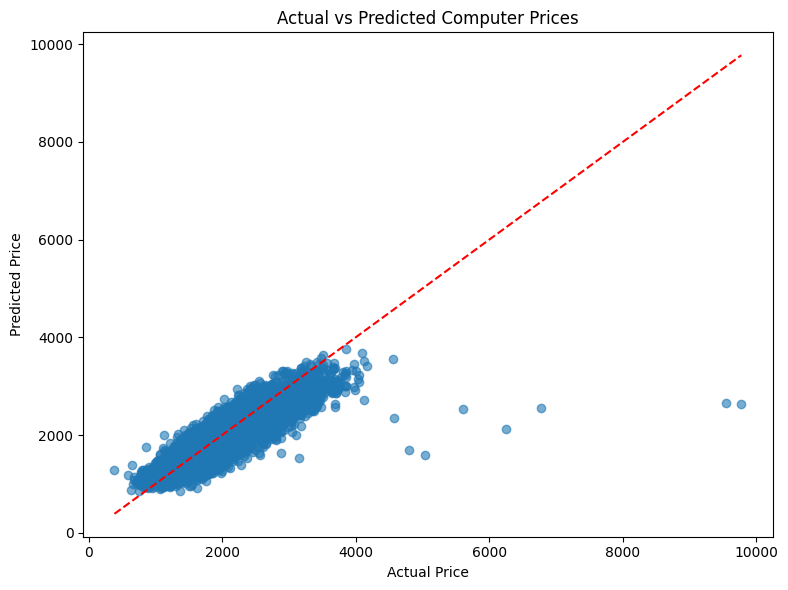

Test MAE:  204.911
Test MSE:  83463.164
Test RMSE: 288.900
Test R²:   0.756


In [ ]:
# Test the model
simple_mae, simple_rmse, simple_r2, simple_preds, true_price = test_model(simple_model, test_loader)

# Comparing against:
# Mean Squared Error: 88621.77347158563
# R^2 Score: 0.7316233647153958

# Best:
# Test MSE:  76753.891
# Test RMSE: 277.045
# Test R²:   0.776

In [ ]:
# Train a more complex model
complex_model = ComplexNN(input_dim=X_train.shape[1])

criterion = nn.SmoothL1Loss(beta=1)

#higher learning rate and different optimizer
#https://docs.pytorch.org/docs/stable/generated/torch.optim.SGD.html
optimizer = optim.SGD(complex_model.parameters(), lr=0.1, momentum=0.9)

train_model(complex_model, train_loader, val_loader, criterion, optimizer, epochs=20, patience=15)

Epoch 01 | train 0.09180 | val 0.01242 | lr 1.00e-01
Epoch 02 | train 0.01358 | val 0.01107 | lr 1.00e-01
Epoch 03 | train 0.01290 | val 0.01036 | lr 1.00e-01
Epoch 04 | train 0.01251 | val 0.01034 | lr 1.00e-01
Epoch 05 | train 0.01217 | val 0.01153 | lr 1.00e-01
Epoch 06 | train 0.01202 | val 0.01060 | lr 1.00e-01
Epoch 07 | train 0.01177 | val 0.00995 | lr 1.00e-01
Epoch 08 | train 0.01163 | val 0.01016 | lr 1.00e-01
Epoch 09 | train 0.01166 | val 0.01024 | lr 1.00e-01
Epoch 10 | train 0.01161 | val 0.01081 | lr 1.00e-01
Epoch 11 | train 0.01146 | val 0.01048 | lr 1.00e-01
Epoch 12 | train 0.01160 | val 0.00980 | lr 1.00e-01
Epoch 13 | train 0.01156 | val 0.00982 | lr 1.00e-01
Epoch 14 | train 0.01137 | val 0.01007 | lr 1.00e-01
Epoch 15 | train 0.01146 | val 0.01023 | lr 1.00e-01
Epoch 16 | train 0.01134 | val 0.00995 | lr 1.00e-01
Epoch 17 | train 0.01125 | val 0.00976 | lr 1.00e-01
Epoch 18 | train 0.01130 | val 0.00978 | lr 1.00e-01
Epoch 19 | train 0.01128 | val 0.00996 | lr 1.

0.009738963107019662

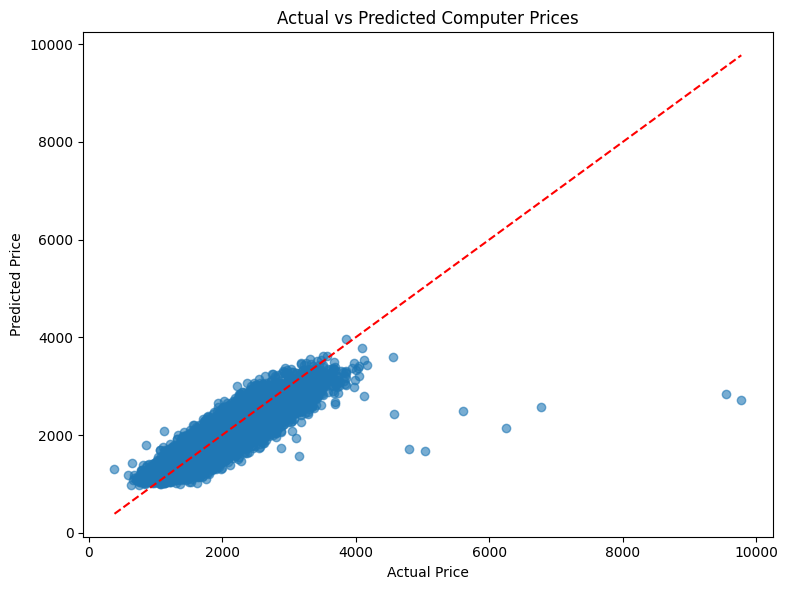

Test MAE:  199.038
Test MSE:  77613.617
Test RMSE: 278.592
Test R²:   0.773


'\nTest MAE:  199.687\nTest MSE:  76970.664\nTest RMSE: 277.436\nTest R²:   0.775\n'

In [ ]:
# Test the more complex model
complex_mae, complex_rmse, complex_r2, complex_preds, _ = test_model(complex_model, test_loader)

"""
Test MAE:  199.687
Test MSE:  76970.664
Test RMSE: 277.436
Test R²:   0.775
"""


           === Model Comparison ===           

       Model         |    MAE     |    RMSE   
----------------------------------------------
   Mean Baseline     |  461.338   |  585.362  
  Median Baseline    |  458.004   |  588.698  
      SimpleNN       |  204.911   |  288.900  
     ComplexNN       |  199.038   |  278.592  


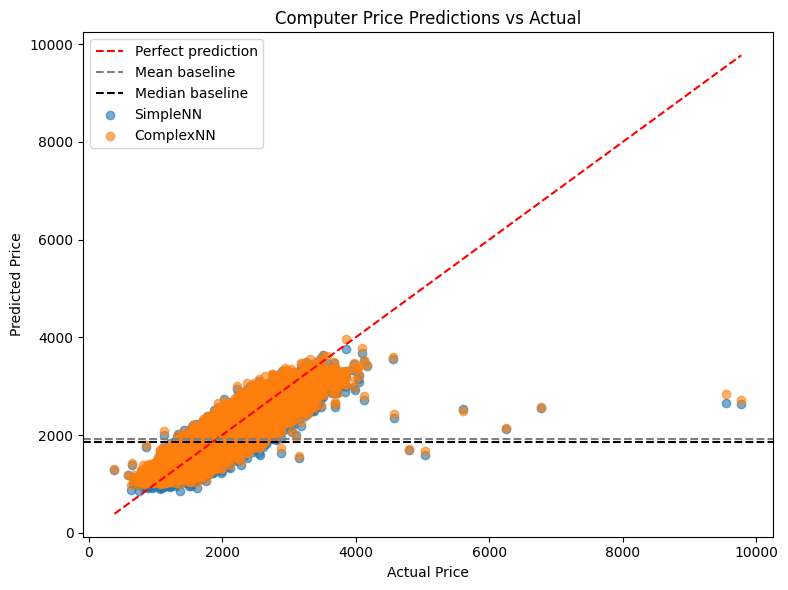

In [ ]:
# Show results
comparison_table = {
    "Mean Baseline": baseline_results["mean"],
    "Median Baseline": baseline_results["median"],
    "SimpleNN": (simple_mae, simple_rmse),
    "ComplexNN": (complex_mae, complex_rmse)
}

table_width = 20 + 3 + 10 + 3 + 10  # Model + separators + MAE + RMSE
print("\n" + "=== Model Comparison ===".center(table_width) + "\n")
header = f"{'Model':^20} | {'MAE':^10} | {'RMSE':^10}"
print(header)
print("-" * len(header))
for name, (mae, rmse) in comparison_table.items():
    print(f"{name:^20} | {mae:^10.3f} | {rmse:^10.3f}")


plt.figure(figsize=(8,6))

min_val = min(true_price.min(), simple_preds.min(), complex_preds.min())
max_val = max(true_price.max(), simple_preds.max(), complex_preds.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Perfect prediction")

plt.axhline(np.mean(np.expm1(Y_train)), color='gray', linestyle='--', label="Mean baseline")
plt.axhline(np.median(np.expm1(Y_train)), color='black', linestyle='--', label="Median baseline")

plt.scatter(true_price, simple_preds, alpha=0.6, label="SimpleNN")
plt.scatter(true_price, complex_preds, alpha=0.6, label="ComplexNN")

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Computer Price Predictions vs Actual")
plt.legend()
plt.tight_layout()
plt.show()


SimpleNN:

Top features associated with LARGE prediction error:
gpu_tier            0.122
ram_gb              0.119
cpu_tier            0.117
cpu_score           0.112
cpu_cores           0.112
cpu_brand_Apple     0.084
brand_Apple         0.084
gpu_brand_Apple     0.065
gpu_score           0.065
gpu_brand_NVIDIA    0.047


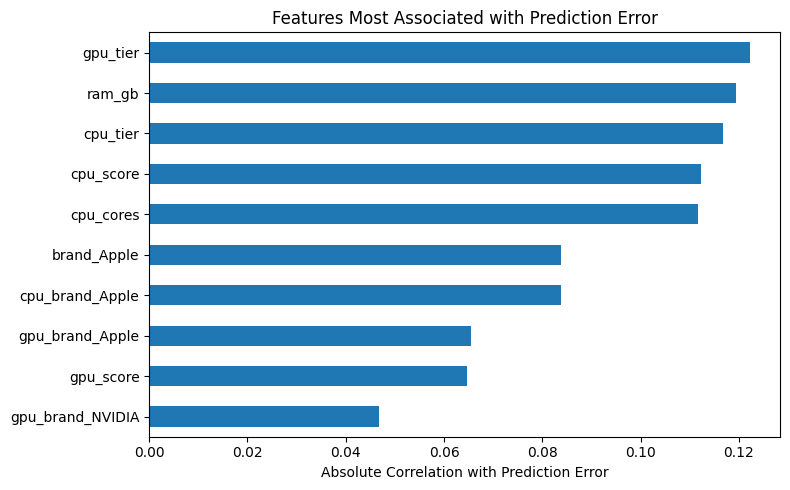


Feature differences (High-error vs Low-error samples):
                  High Error Mean  Low Error Mean  Difference
gpu_tier                    0.214          -0.077       0.290
ram_gb                      0.217          -0.064       0.281
cpu_tier                    0.196          -0.059       0.255
cpu_score                   0.198          -0.054       0.251
cpu_cores                   0.188          -0.054       0.243
gpu_score                   0.125          -0.039       0.164
gpu_brand_Apple             0.228           0.174       0.054
cpu_brand_Apple             0.154           0.104       0.050
brand_Apple                 0.154           0.104       0.050
gpu_brand_NVIDIA            0.513           0.563      -0.050

ComplexNN:

Top features associated with LARGE prediction error:
gpu_tier            0.114
ram_gb              0.114
cpu_tier            0.111
cpu_score           0.111
cpu_cores           0.110
cpu_brand_Apple     0.079
brand_Apple         0.079
gpu_brand_Appl

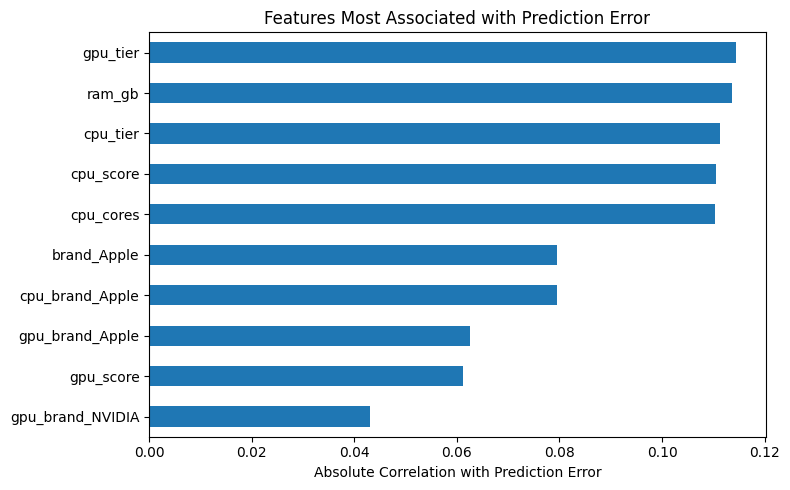


Feature differences (High-error vs Low-error samples):
                  High Error Mean  Low Error Mean  Difference
gpu_tier                    0.217          -0.078       0.295
ram_gb                      0.224          -0.066       0.290
cpu_tier                    0.209          -0.063       0.273
cpu_score                   0.212          -0.058       0.271
cpu_cores                   0.205          -0.060       0.266
gpu_score                   0.124          -0.039       0.163
gpu_brand_Apple             0.231           0.173       0.058
gpu_brand_NVIDIA            0.509           0.564      -0.055
cpu_brand_Apple             0.158           0.103       0.055
brand_Apple                 0.158           0.103       0.055


(        Predicted       Actual  AbsoluteError
 0     1255.112061   932.989868     322.122192
 1     1764.674072  1893.990234     129.316162
 2     1879.079224  1964.989990      85.910767
 3     1221.542969  1190.989746      30.553223
 4     2149.610840  1798.989868     350.620972
 ...           ...          ...            ...
 9995  1282.788574  1464.989990     182.201416
 9996  1196.435303   868.989990     327.445312
 9997  2509.771484  2294.989746     214.781738
 9998  2372.617676  2142.990234     229.627441
 9999  1635.821777  1276.989868     358.831909
 
 [10000 rows x 3 columns],
 gpu_tier            0.114486
 ram_gb              0.113733
 cpu_tier            0.111354
 cpu_score           0.110544
 cpu_cores           0.110302
 cpu_brand_Apple     0.079444
 brand_Apple         0.079444
 gpu_brand_Apple     0.062587
 gpu_score           0.061197
 gpu_brand_NVIDIA    0.043046
 dtype: float64,
                   High Error Mean  Low Error Mean  Difference
 gpu_tier                 0

In [ ]:
# Error analysis
print("SimpleNN:")
error_analysis_with_plots(
    model_preds=simple_preds,
    true_values=true_price,
    X_features=X_test,
    feature_names=X_train.columns,
    top_n=10
)

print("\nComplexNN:")
error_analysis_with_plots(
    model_preds=complex_preds,
    true_values=true_price,
    X_features=X_test,
    feature_names=X_train.columns,
    top_n=10
)



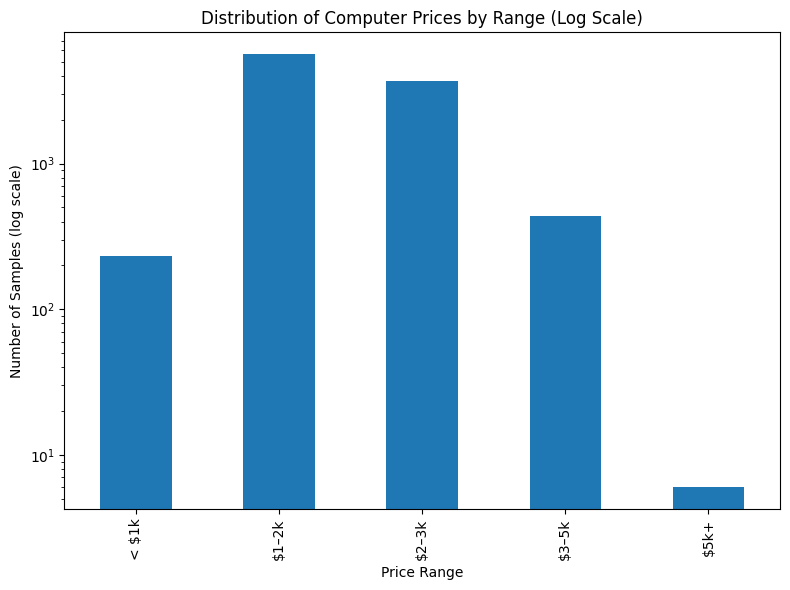

In [ ]:
def plot_price_distribution_log(true_price):
    df = pd.DataFrame({"Price": true_price})

    bins = [0, 1000, 2000, 3000, 5000, 10000]
    labels = ["< $1k", "$1–2k", "$2–3k", "$3–5k", "$5k+"]

    df["PriceRange"] = pd.cut(df["Price"], bins=bins, labels=labels)

    # Count samples in each bucket
    counts = df["PriceRange"].value_counts().sort_index()

    plt.figure(figsize=(8, 6))
    counts.plot(kind="bar")

    plt.yscale("log")
    plt.xlabel("Price Range")
    plt.ylabel("Number of Samples (log scale)")
    plt.title("Distribution of Computer Prices by Range (Log Scale)")
    plt.tight_layout()
    plt.show()

plot_price_distribution_log(true_price)

/tmp/ipython-input-2120516854.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby("price_bucket")[["simple_error", "complex_error"]].mean()


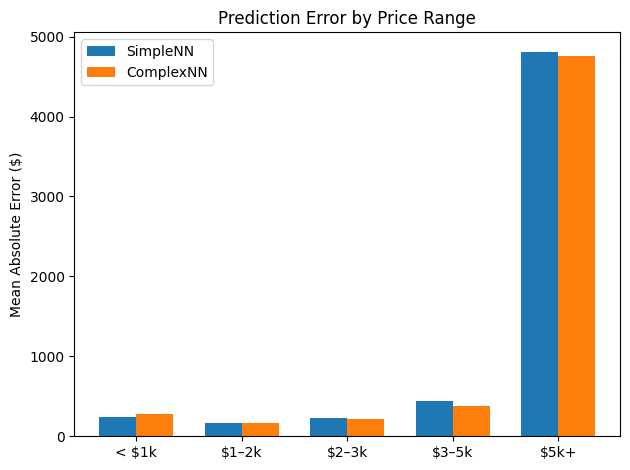

,simple_error,complex_error
price_bucket,,
< $1k,237.902069,281.790710
$1–2k,166.326630,167.879776
$2–3k,226.654510,212.349533
$3–5k,441.875854,384.802216
$5k+,4813.029785,4751.829590


In [ ]:
PRICE_BINS = [0, 1000, 2000, 3000, 5000, np.inf]
PRICE_LABELS = ["< $1k", "$1–2k", "$2–3k", "$3–5k", "$5k+"]

def error_by_price_bucket_fixed(y_true, simple_preds, complex_preds):
    df = pd.DataFrame({
        "price": y_true,
        "simple_error": np.abs(simple_preds - y_true),
        "complex_error": np.abs(complex_preds - y_true),
    })

    df["price_bucket"] = pd.cut(
        df["price"],
        bins=PRICE_BINS,
        labels=PRICE_LABELS,
        right=False
    )

    summary = df.groupby("price_bucket")[["simple_error", "complex_error"]].mean()

    x = np.arange(len(summary))
    width = 0.35

    plt.figure()
    plt.bar(x - width/2, summary["simple_error"], width, label="SimpleNN")
    plt.bar(x + width/2, summary["complex_error"], width, label="ComplexNN")

    plt.xticks(x, summary.index)
    plt.ylabel("Mean Absolute Error ($)")
    plt.title("Prediction Error by Price Range")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return summary

error_by_price_bucket_fixed(true_price, simple_preds, complex_preds)
